# Step 2: Parameter Estimation Methods Comparison

**Goal**: Explain how the authors estimate parameters in the adaptive Heston paper, and compare with other MLE methods (Simplex, EM algorithm).

This notebook uses the refactored `HestonModel` class for a clean, modular approach.


## Project Requirements

From Professor Chopin's email:

> 2. explain how the authors estimate the theta based on real data, and compare to other (MLE) methods, see the corresponding chapter. In particular, discuss you could use the simplex and / or the EM algorithm.

This notebook addresses:

- **Part A**: Explanation of the paper's approach (NMLE + switching filters)
- **Part B**: Implementation and comparison of different estimation methods:
  - PMMH (Particle Marginal Metropolis-Hastings) - Bayesian approach
  - Simplex (Nelder-Mead) - Direct optimization
  - EM (Expectation-Maximization) - Iterative optimization
- **Part C**: Comparison and analysis of results


In [52]:
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os

# Add parent directory to path to import heston package
sys.path.insert(0, os.path.abspath('../..'))

from heston import HestonModel
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

plt.style.use('ggplot')
print("Setup complete!")


Setup complete!


## Part A: Paper's Approach - NMLE with Switching Filters

### How the Authors Estimate Parameters

The paper "Adaptive calibration of Heston Model using PCRLB based switching Filter" by Kumar Yashaswi uses:

1. **Normal Maximum Likelihood Estimation (NMLE)**: A method that transforms the Heston model to get an exact Gaussian distribution (rather than approximate).

2. **Switching Filter Strategy**: Uses PCRLB (Posterior Cramer-Rao Lower Bound) to switch between different Bayesian filters (EKF, UKF, PF) at each time step.

3. **Alternating Approach**:
   - Use filtering (EKF/UKF/PF) to estimate volatility
   - Use NMLE to estimate parameters (given estimated volatilities)
   - Repeat until convergence

### Key Differences from Our Approach

- **Paper**: Uses NMLE (requires known volatilities) + switching filters
- **Our approach**: Uses PMMH (Bayesian MCMC) which estimates parameters directly from data

### NMLE Method (from paper)

The NMLE formulas require **known volatilities** $V_k$:

$$\\hat{\\kappa} = \\frac{2}{\\delta}\\left(1 + \\frac{\\hat{P}\\delta}{2} \\frac{1}{n}\\sum_{k=1}^n \\frac{1}{V_{k-1}} - \\frac{1}{n}\\sum_{k=1}^n \\sqrt{\\frac{V_k}{V_{k-1}}}\\right)$$

$$\\hat{\\sigma} = \\sqrt{\\frac{4}{\\delta} \\frac{1}{n}\\sum_{k=1}^n \\left[\\sqrt{V_k} - \\sqrt{V_{k-1}} - \\frac{\\delta}{2\\sqrt{V_{k-1}}}(\\hat{P} - \\hat{\\kappa}V_{k-1})\\right]^2}$$

$$\\hat{\\theta} = \\frac{\\hat{P} + \\frac{1}{4}\\hat{\\sigma}^2}{\\hat{\\kappa}}$$

**Note**: Since we use PMMH (which doesn't require known volatilities), we focus on comparing PMMH with other direct optimization methods (Simplex, EM).


## Part B: Comparison of Estimation Methods

We'll compare three different approaches:

1. **PMMH (Particle Marginal Metropolis-Hastings)**: Bayesian MCMC method
2. **Simplex (Nelder-Mead)**: Direct optimization of log-likelihood
3. **EM (Expectation-Maximization)**: Iterative optimization using particle filter

### Load Data

We'll use the same S&P 500 data as in Step 1.


In [53]:
# Initialize model and load data
hest = HestonModel(dt=1 / 252, r=0.04)

print("Loading market data...")
hest.load_data(ticker="^GSPC", start="2007-01-01", end="2025-12-31")

print(f"\nLoaded {len(hest.data)} observations")
print(f"Date range: {hest.dates[0].date()} to {hest.dates[-1].date()}")

INFO: Downloading ^GSPC data from 2007-01-01 to 2025-12-31
INFO: Computed 4778 log returns
INFO: Downloading risk-free rate from ^IRX
INFO: Risk-free rate statistics:
INFO:   Mean: 0.0146
INFO:   Std: 0.0182
INFO:   Min: -0.0010, Max: 0.0535
INFO: Loaded 4778 observations


Loading market data...

Loaded 4778 observations
Date range: 2007-01-04 to 2025-12-30


### Method 1: PMMH (Particle Marginal Metropolis-Hastings)

**What it is**: Bayesian MCMC method that samples from the posterior distribution of parameters.

**Advantages**:

- Provides full posterior distribution (not just point estimates)
- Handles uncertainty quantification
- No need for known volatilities

**Disadvantages**:

- Computationally expensive (requires many MCMC iterations)
- Requires prior distributions
- May have mixing issues


In [54]:
# Define prior for PMMH
from particles import distributions as dists

params_pmmh_list = []
for i in range(10):
    hest = HestonModel(dt=1 / 252, r=0.04)

    print("Loading market data...")
    hest.load_data(ticker="^GSPC", start="2007-01-01", end="2025-12-31")
    prior_dict = {
        'kappa': dists.Gamma(a=2.0, b=1.0),  # Mean ~2, variance ~2
        'theta': dists.Gamma(a=2.0, b=40.0),  # Mean ~0.05, variance ~0.00125
        'sigma': dists.Gamma(a=2.0, b=2.5),  # Mean ~0.8, variance ~0.32
        'rho': dists.Uniform(a=-0.99, b=0.99),  # Correlation
        'v0': dists.Dirac(0.04),  # Fixed initial variance
        'dt': dists.Dirac(1 / 252),  # Fixed daily time step
    }

    my_prior = dists.StructDist(prior_dict)

    print("Running PMMH (this will take several minutes)...")
    print(
        "Note: For faster testing, we use fewer iterations. For final results, use n_iter=10000, burnin=1000"
    )
    n_iter = 10000  # Reduced for faster testing

    results_pmmh = hest.estimate_parameters(
        method='pmmh',
        n_iter=n_iter,  # Reduced for faster testing
        n_particles=20000,
        prior=my_prior,
        burnin=n_iter // 10,  # 10% burn-in
        verbose=True,
    )

    params_pmmh = hest.estimated_params.copy()
    print("\n=== PMMH Results ===")
    for param, value in params_pmmh.items():
        print(f"  {param}: {value:.4f}")
    params_pmmh_list.append(params_pmmh)

INFO: Downloading ^GSPC data from 2007-01-01 to 2025-12-31
INFO: Computed 4778 log returns
INFO: Downloading risk-free rate from ^IRX
INFO: Risk-free rate statistics:
INFO:   Mean: 0.0146
INFO:   Std: 0.0182
INFO:   Min: -0.0010, Max: 0.0535
INFO: Loaded 4778 observations
INFO: Filtering out fixed parameters from prior: ['dt', 'v0']
INFO: Running PMMH with 10000 iterations...
INFO: Using 20000 particles per PF run
INFO: Data length: 4778 observations
INFO: Burn-in: 1000 iterations (will use 9000 samples for posterior)
INFO: Estimated time: ~19112-38224 minutes (rough estimate)
INFO: Note: PMMH runs silently without progress updates - this is normal.
INFO:       The particles library doesn't provide progress bars for PMMH.
INFO: Starting PMMH...


Loading market data...
Running PMMH (this will take several minutes)...
Note: For faster testing, we use fewer iterations. For final results, use n_iter=10000, burnin=1000


INFO: PMMH completed!
Suggestions to improve mixing:

INFO: 
=== PMMH Posterior Statistics ===
INFO: kappa   : mean=0.3950, std=0.0000, 95% CI=[0.3950, 0.3950]
INFO: theta   : mean=0.0532, std=0.0000, 95% CI=[0.0532, 0.0532]
INFO: sigma   : mean=1.2636, std=0.0000, 95% CI=[1.2636, 1.2636]
INFO: rho     : mean=0.0474, std=0.0000, 95% CI=[0.0474, 0.0474]
INFO: Downloading ^GSPC data from 2007-01-01 to 2025-12-31
INFO: Computed 4778 log returns
INFO: Downloading risk-free rate from ^IRX
INFO: Risk-free rate statistics:
INFO:   Mean: 0.0146
INFO:   Std: 0.0182
INFO:   Min: -0.0010, Max: 0.0535
INFO: Loaded 4778 observations
INFO: Filtering out fixed parameters from prior: ['dt', 'v0']
INFO: Running PMMH with 10000 iterations...
INFO: Using 20000 particles per PF run
INFO: Data length: 4778 observations
INFO: Burn-in: 1000 iterations (will use 9000 samples for posterior)
INFO: Estimated time: ~19112-38224 minutes (rough estimate)
INFO: Note: PMMH runs silently without progress updates - thi


=== PMMH Results ===
  kappa: 0.3950
  theta: 0.0532
  sigma: 1.2636
  rho: 0.0474
Loading market data...
Running PMMH (this will take several minutes)...
Note: For faster testing, we use fewer iterations. For final results, use n_iter=10000, burnin=1000


INFO: PMMH completed!
Suggestions to improve mixing:

INFO: 
=== PMMH Posterior Statistics ===
INFO: kappa   : mean=0.6831, std=0.0000, 95% CI=[0.6831, 0.6831]
INFO: theta   : mean=0.1043, std=0.0000, 95% CI=[0.1043, 0.1043]
INFO: sigma   : mean=0.6482, std=0.0000, 95% CI=[0.6482, 0.6482]
INFO: rho     : mean=0.3922, std=0.0000, 95% CI=[0.3922, 0.3922]
INFO: Downloading ^GSPC data from 2007-01-01 to 2025-12-31
INFO: Computed 4778 log returns
INFO: Downloading risk-free rate from ^IRX
INFO: Risk-free rate statistics:
INFO:   Mean: 0.0146
INFO:   Std: 0.0182
INFO:   Min: -0.0010, Max: 0.0535
INFO: Loaded 4778 observations
INFO: Filtering out fixed parameters from prior: ['dt', 'v0']
INFO: Running PMMH with 10000 iterations...
INFO: Using 20000 particles per PF run
INFO: Data length: 4778 observations
INFO: Burn-in: 1000 iterations (will use 9000 samples for posterior)
INFO: Estimated time: ~19112-38224 minutes (rough estimate)
INFO: Note: PMMH runs silently without progress updates - thi


=== PMMH Results ===
  kappa: 0.6831
  theta: 0.1043
  sigma: 0.6482
  rho: 0.3922
Loading market data...
Running PMMH (this will take several minutes)...
Note: For faster testing, we use fewer iterations. For final results, use n_iter=10000, burnin=1000


INFO: PMMH completed!
Suggestions to improve mixing:

INFO: 
=== PMMH Posterior Statistics ===
INFO: kappa   : mean=0.8807, std=0.0000, 95% CI=[0.8807, 0.8807]
INFO: theta   : mean=0.0841, std=0.0000, 95% CI=[0.0841, 0.0841]
INFO: sigma   : mean=0.5633, std=0.0000, 95% CI=[0.5633, 0.5633]
INFO: rho     : mean=-0.9033, std=0.0000, 95% CI=[-0.9033, -0.9033]
INFO: Downloading ^GSPC data from 2007-01-01 to 2025-12-31
INFO: Computed 4778 log returns
INFO: Downloading risk-free rate from ^IRX
INFO: Risk-free rate statistics:
INFO:   Mean: 0.0146
INFO:   Std: 0.0182
INFO:   Min: -0.0010, Max: 0.0535
INFO: Loaded 4778 observations
INFO: Filtering out fixed parameters from prior: ['dt', 'v0']
INFO: Running PMMH with 10000 iterations...
INFO: Using 20000 particles per PF run
INFO: Data length: 4778 observations
INFO: Burn-in: 1000 iterations (will use 9000 samples for posterior)
INFO: Estimated time: ~19112-38224 minutes (rough estimate)
INFO: Note: PMMH runs silently without progress updates - 


=== PMMH Results ===
  kappa: 0.8807
  theta: 0.0841
  sigma: 0.5633
  rho: -0.9033
Loading market data...
Running PMMH (this will take several minutes)...
Note: For faster testing, we use fewer iterations. For final results, use n_iter=10000, burnin=1000


INFO: PMMH completed!
Suggestions to improve mixing:

INFO: 
=== PMMH Posterior Statistics ===
INFO: kappa   : mean=3.9566, std=0.0000, 95% CI=[3.9566, 3.9566]
INFO: theta   : mean=0.0740, std=0.0000, 95% CI=[0.0740, 0.0740]
INFO: sigma   : mean=1.0143, std=0.0000, 95% CI=[1.0143, 1.0143]
INFO: rho     : mean=-0.7335, std=0.0000, 95% CI=[-0.7335, -0.7335]
INFO: Downloading ^GSPC data from 2007-01-01 to 2025-12-31
INFO: Computed 4778 log returns
INFO: Downloading risk-free rate from ^IRX
INFO: Risk-free rate statistics:
INFO:   Mean: 0.0146
INFO:   Std: 0.0182
INFO:   Min: -0.0010, Max: 0.0535
INFO: Loaded 4778 observations
INFO: Filtering out fixed parameters from prior: ['dt', 'v0']
INFO: Running PMMH with 10000 iterations...
INFO: Using 20000 particles per PF run
INFO: Data length: 4778 observations
INFO: Burn-in: 1000 iterations (will use 9000 samples for posterior)
INFO: Estimated time: ~19112-38224 minutes (rough estimate)
INFO: Note: PMMH runs silently without progress updates - 


=== PMMH Results ===
  kappa: 3.9566
  theta: 0.0740
  sigma: 1.0143
  rho: -0.7335
Loading market data...
Running PMMH (this will take several minutes)...
Note: For faster testing, we use fewer iterations. For final results, use n_iter=10000, burnin=1000


INFO: PMMH completed!
Suggestions to improve mixing:

INFO: 
=== PMMH Posterior Statistics ===
INFO: kappa   : mean=4.1458, std=0.0000, 95% CI=[4.1458, 4.1458]
INFO: theta   : mean=0.0207, std=0.0000, 95% CI=[0.0207, 0.0207]
INFO: sigma   : mean=0.6506, std=0.0000, 95% CI=[0.6506, 0.6506]
INFO: rho     : mean=-0.7531, std=0.0000, 95% CI=[-0.7531, -0.7531]
INFO: Downloading ^GSPC data from 2007-01-01 to 2025-12-31
INFO: Computed 4778 log returns
INFO: Downloading risk-free rate from ^IRX
INFO: Risk-free rate statistics:
INFO:   Mean: 0.0146
INFO:   Std: 0.0182
INFO:   Min: -0.0010, Max: 0.0535
INFO: Loaded 4778 observations
INFO: Filtering out fixed parameters from prior: ['dt', 'v0']
INFO: Running PMMH with 10000 iterations...
INFO: Using 20000 particles per PF run
INFO: Data length: 4778 observations
INFO: Burn-in: 1000 iterations (will use 9000 samples for posterior)
INFO: Estimated time: ~19112-38224 minutes (rough estimate)
INFO: Note: PMMH runs silently without progress updates - 


=== PMMH Results ===
  kappa: 4.1458
  theta: 0.0207
  sigma: 0.6506
  rho: -0.7531
Loading market data...
Running PMMH (this will take several minutes)...
Note: For faster testing, we use fewer iterations. For final results, use n_iter=10000, burnin=1000


INFO: PMMH completed!
Suggestions to improve mixing:

INFO: 
=== PMMH Posterior Statistics ===
INFO: kappa   : mean=2.6906, std=0.0000, 95% CI=[2.6906, 2.6906]
INFO: theta   : mean=0.0206, std=0.0000, 95% CI=[0.0206, 0.0206]
INFO: sigma   : mean=0.9418, std=0.0000, 95% CI=[0.9418, 0.9418]
INFO: rho     : mean=-0.9877, std=0.0000, 95% CI=[-0.9877, -0.9877]
INFO: Downloading ^GSPC data from 2007-01-01 to 2025-12-31
INFO: Computed 4778 log returns
INFO: Downloading risk-free rate from ^IRX
INFO: Risk-free rate statistics:
INFO:   Mean: 0.0146
INFO:   Std: 0.0182
INFO:   Min: -0.0010, Max: 0.0535
INFO: Loaded 4778 observations
INFO: Filtering out fixed parameters from prior: ['dt', 'v0']
INFO: Running PMMH with 10000 iterations...
INFO: Using 20000 particles per PF run
INFO: Data length: 4778 observations
INFO: Burn-in: 1000 iterations (will use 9000 samples for posterior)
INFO: Estimated time: ~19112-38224 minutes (rough estimate)
INFO: Note: PMMH runs silently without progress updates - 


=== PMMH Results ===
  kappa: 2.6906
  theta: 0.0206
  sigma: 0.9418
  rho: -0.9877
Loading market data...
Running PMMH (this will take several minutes)...
Note: For faster testing, we use fewer iterations. For final results, use n_iter=10000, burnin=1000


INFO: PMMH completed!
Suggestions to improve mixing:

INFO: 
=== PMMH Posterior Statistics ===
INFO: kappa   : mean=1.4169, std=0.0000, 95% CI=[1.4169, 1.4169]
INFO: theta   : mean=0.0152, std=0.0000, 95% CI=[0.0152, 0.0152]
INFO: sigma   : mean=0.9687, std=0.0000, 95% CI=[0.9687, 0.9687]
INFO: rho     : mean=0.1640, std=0.0000, 95% CI=[0.1640, 0.1640]
INFO: Downloading ^GSPC data from 2007-01-01 to 2025-12-31
INFO: Computed 4778 log returns
INFO: Downloading risk-free rate from ^IRX
INFO: Risk-free rate statistics:
INFO:   Mean: 0.0146
INFO:   Std: 0.0182
INFO:   Min: -0.0010, Max: 0.0535
INFO: Loaded 4778 observations
INFO: Filtering out fixed parameters from prior: ['dt', 'v0']
INFO: Running PMMH with 10000 iterations...
INFO: Using 20000 particles per PF run
INFO: Data length: 4778 observations
INFO: Burn-in: 1000 iterations (will use 9000 samples for posterior)
INFO: Estimated time: ~19112-38224 minutes (rough estimate)
INFO: Note: PMMH runs silently without progress updates - thi


=== PMMH Results ===
  kappa: 1.4169
  theta: 0.0152
  sigma: 0.9687
  rho: 0.1640
Loading market data...
Running PMMH (this will take several minutes)...
Note: For faster testing, we use fewer iterations. For final results, use n_iter=10000, burnin=1000


INFO: PMMH completed!
Suggestions to improve mixing:

INFO: 
=== PMMH Posterior Statistics ===
INFO: kappa   : mean=4.4668, std=0.0000, 95% CI=[4.4668, 4.4668]
INFO: theta   : mean=0.0952, std=0.0000, 95% CI=[0.0952, 0.0952]
INFO: sigma   : mean=0.5363, std=0.0000, 95% CI=[0.5363, 0.5363]
INFO: rho     : mean=0.9316, std=0.0000, 95% CI=[0.9316, 0.9316]
INFO: Downloading ^GSPC data from 2007-01-01 to 2025-12-31
INFO: Computed 4778 log returns
INFO: Downloading risk-free rate from ^IRX
INFO: Risk-free rate statistics:
INFO:   Mean: 0.0146
INFO:   Std: 0.0182
INFO:   Min: -0.0010, Max: 0.0535
INFO: Loaded 4778 observations
INFO: Filtering out fixed parameters from prior: ['dt', 'v0']
INFO: Running PMMH with 10000 iterations...
INFO: Using 20000 particles per PF run
INFO: Data length: 4778 observations
INFO: Burn-in: 1000 iterations (will use 9000 samples for posterior)
INFO: Estimated time: ~19112-38224 minutes (rough estimate)
INFO: Note: PMMH runs silently without progress updates - thi


=== PMMH Results ===
  kappa: 4.4668
  theta: 0.0952
  sigma: 0.5363
  rho: 0.9316
Loading market data...
Running PMMH (this will take several minutes)...
Note: For faster testing, we use fewer iterations. For final results, use n_iter=10000, burnin=1000


INFO: PMMH completed!
Suggestions to improve mixing:

INFO: 
=== PMMH Posterior Statistics ===
INFO: kappa   : mean=4.3597, std=0.0000, 95% CI=[4.3597, 4.3597]
INFO: theta   : mean=0.0713, std=0.0000, 95% CI=[0.0713, 0.0713]
INFO: sigma   : mean=1.7598, std=0.0000, 95% CI=[1.7598, 1.7598]
INFO: rho     : mean=-0.1705, std=0.0000, 95% CI=[-0.1705, -0.1705]
INFO: Downloading ^GSPC data from 2007-01-01 to 2025-12-31
INFO: Computed 4778 log returns
INFO: Downloading risk-free rate from ^IRX
INFO: Risk-free rate statistics:
INFO:   Mean: 0.0146
INFO:   Std: 0.0182
INFO:   Min: -0.0010, Max: 0.0535
INFO: Loaded 4778 observations
INFO: Filtering out fixed parameters from prior: ['dt', 'v0']
INFO: Running PMMH with 10000 iterations...
INFO: Using 20000 particles per PF run
INFO: Data length: 4778 observations
INFO: Burn-in: 1000 iterations (will use 9000 samples for posterior)
INFO: Estimated time: ~19112-38224 minutes (rough estimate)
INFO: Note: PMMH runs silently without progress updates - 


=== PMMH Results ===
  kappa: 4.3597
  theta: 0.0713
  sigma: 1.7598
  rho: -0.1705
Loading market data...
Running PMMH (this will take several minutes)...
Note: For faster testing, we use fewer iterations. For final results, use n_iter=10000, burnin=1000


INFO: PMMH completed!
Suggestions to improve mixing:

INFO: 
=== PMMH Posterior Statistics ===
INFO: kappa   : mean=6.0045, std=0.0000, 95% CI=[6.0045, 6.0045]
INFO: theta   : mean=0.0480, std=0.0000, 95% CI=[0.0480, 0.0480]
INFO: sigma   : mean=0.3639, std=0.0000, 95% CI=[0.3639, 0.3639]
INFO: rho     : mean=0.5439, std=0.0000, 95% CI=[0.5439, 0.5439]



=== PMMH Results ===
  kappa: 6.0045
  theta: 0.0480
  sigma: 0.3639
  rho: 0.5439


In [55]:
params_simplex_list = []
for i in range(10):

    hest = HestonModel(dt=1 / 252, r=0.04)

    hest.load_data(ticker="^GSPC", start="2007-01-01", end="2025-12-31")
    print("Running Simplex (Nelder-Mead) optimization...")

    results_simplex = hest.estimate_parameters(
        method='simplex',
        n_particles=2000,
        initial_params={'kappa': 2.0, 'theta': 0.04, 'sigma': 0.3, 'rho': -0.7},
        verbose=True,
    )

    params_simplex = hest.estimated_params.copy()
    print("\n=== Simplex Results ===")
    for param, value in params_simplex.items():
        print(f"  {param}: {value:.4f}")
    params_simplex_list.append(params_simplex)

INFO: Downloading ^GSPC data from 2007-01-01 to 2025-12-31
INFO: Computed 4778 log returns
INFO: Downloading risk-free rate from ^IRX
INFO: Risk-free rate statistics:
INFO:   Mean: 0.0146
INFO:   Std: 0.0182
INFO:   Min: -0.0010, Max: 0.0535
INFO: Loaded 4778 observations
INFO: Running Nelder-Mead optimization...


Running Simplex (Nelder-Mead) optimization...


INFO: 
=== Simplex Optimization Results ===
INFO: kappa   : 2.0105
INFO: theta   : 0.0401
INFO: sigma   : 0.2992
INFO: rho     : -0.7321
INFO: Log-likelihood: 15469.26
INFO: Downloading ^GSPC data from 2007-01-01 to 2025-12-31
INFO: Computed 4778 log returns
INFO: Downloading risk-free rate from ^IRX
INFO: Risk-free rate statistics:
INFO:   Mean: 0.0146
INFO:   Std: 0.0182
INFO:   Min: -0.0010, Max: 0.0535
INFO: Loaded 4778 observations
INFO: Running Nelder-Mead optimization...



=== Simplex Results ===
  kappa: 2.0105
  theta: 0.0401
  sigma: 0.2992
  rho: -0.7321
Running Simplex (Nelder-Mead) optimization...


INFO: 
=== Simplex Optimization Results ===
INFO: kappa   : 2.0335
INFO: theta   : 0.0387
INFO: sigma   : 0.3189
INFO: rho     : -0.7225
INFO: Log-likelihood: 15477.32
INFO: Downloading ^GSPC data from 2007-01-01 to 2025-12-31
INFO: Computed 4778 log returns
INFO: Downloading risk-free rate from ^IRX
INFO: Risk-free rate statistics:
INFO:   Mean: 0.0146
INFO:   Std: 0.0182
INFO:   Min: -0.0010, Max: 0.0535
INFO: Loaded 4778 observations
INFO: Running Nelder-Mead optimization...



=== Simplex Results ===
  kappa: 2.0335
  theta: 0.0387
  sigma: 0.3189
  rho: -0.7225
Running Simplex (Nelder-Mead) optimization...


INFO: 
=== Simplex Optimization Results ===
INFO: kappa   : 1.9262
INFO: theta   : 0.0363
INFO: sigma   : 0.4083
INFO: rho     : -0.6362
INFO: Log-likelihood: 15502.95
INFO: Downloading ^GSPC data from 2007-01-01 to 2025-12-31
INFO: Computed 4778 log returns
INFO: Downloading risk-free rate from ^IRX
INFO: Risk-free rate statistics:
INFO:   Mean: 0.0146
INFO:   Std: 0.0182
INFO:   Min: -0.0010, Max: 0.0535
INFO: Loaded 4778 observations
INFO: Running Nelder-Mead optimization...



=== Simplex Results ===
  kappa: 1.9262
  theta: 0.0363
  sigma: 0.4083
  rho: -0.6362
Running Simplex (Nelder-Mead) optimization...


INFO: 
=== Simplex Optimization Results ===
INFO: kappa   : 2.0371
INFO: theta   : 0.0402
INFO: sigma   : 0.3233
INFO: rho     : -0.6584
INFO: Log-likelihood: 15480.79
INFO: Downloading ^GSPC data from 2007-01-01 to 2025-12-31
INFO: Computed 4778 log returns
INFO: Downloading risk-free rate from ^IRX
INFO: Risk-free rate statistics:
INFO:   Mean: 0.0146
INFO:   Std: 0.0182
INFO:   Min: -0.0010, Max: 0.0535
INFO: Loaded 4778 observations
INFO: Running Nelder-Mead optimization...



=== Simplex Results ===
  kappa: 2.0371
  theta: 0.0402
  sigma: 0.3233
  rho: -0.6584
Running Simplex (Nelder-Mead) optimization...


INFO: 
=== Simplex Optimization Results ===
INFO: kappa   : 1.9775
INFO: theta   : 0.0421
INFO: sigma   : 0.3235
INFO: rho     : -0.6784
INFO: Log-likelihood: 15483.82
INFO: Downloading ^GSPC data from 2007-01-01 to 2025-12-31
INFO: Computed 4778 log returns
INFO: Downloading risk-free rate from ^IRX
INFO: Risk-free rate statistics:
INFO:   Mean: 0.0146
INFO:   Std: 0.0182
INFO:   Min: -0.0010, Max: 0.0535
INFO: Loaded 4778 observations
INFO: Running Nelder-Mead optimization...



=== Simplex Results ===
  kappa: 1.9775
  theta: 0.0421
  sigma: 0.3235
  rho: -0.6784
Running Simplex (Nelder-Mead) optimization...


INFO: 
=== Simplex Optimization Results ===
INFO: kappa   : 1.9666
INFO: theta   : 0.0385
INFO: sigma   : 0.3315
INFO: rho     : -0.6917
INFO: Log-likelihood: 15485.83
INFO: Downloading ^GSPC data from 2007-01-01 to 2025-12-31
INFO: Computed 4778 log returns
INFO: Downloading risk-free rate from ^IRX
INFO: Risk-free rate statistics:
INFO:   Mean: 0.0146
INFO:   Std: 0.0182
INFO:   Min: -0.0010, Max: 0.0535
INFO: Loaded 4778 observations
INFO: Running Nelder-Mead optimization...



=== Simplex Results ===
  kappa: 1.9666
  theta: 0.0385
  sigma: 0.3315
  rho: -0.6917
Running Simplex (Nelder-Mead) optimization...


INFO: 
=== Simplex Optimization Results ===
INFO: kappa   : 1.9499
INFO: theta   : 0.0360
INFO: sigma   : 0.3804
INFO: rho     : -0.6092
INFO: Log-likelihood: 15499.67
INFO: Downloading ^GSPC data from 2007-01-01 to 2025-12-31
INFO: Computed 4778 log returns
INFO: Downloading risk-free rate from ^IRX
INFO: Risk-free rate statistics:
INFO:   Mean: 0.0146
INFO:   Std: 0.0182
INFO:   Min: -0.0010, Max: 0.0535
INFO: Loaded 4778 observations
INFO: Running Nelder-Mead optimization...



=== Simplex Results ===
  kappa: 1.9499
  theta: 0.0360
  sigma: 0.3804
  rho: -0.6092
Running Simplex (Nelder-Mead) optimization...


INFO: 
=== Simplex Optimization Results ===
INFO: kappa   : 2.0251
INFO: theta   : 0.0327
INFO: sigma   : 0.4147
INFO: rho     : -0.7078
INFO: Log-likelihood: 15500.05
INFO: Downloading ^GSPC data from 2007-01-01 to 2025-12-31
INFO: Computed 4778 log returns
INFO: Downloading risk-free rate from ^IRX
INFO: Risk-free rate statistics:
INFO:   Mean: 0.0146
INFO:   Std: 0.0182
INFO:   Min: -0.0010, Max: 0.0535
INFO: Loaded 4778 observations
INFO: Running Nelder-Mead optimization...



=== Simplex Results ===
  kappa: 2.0251
  theta: 0.0327
  sigma: 0.4147
  rho: -0.7078
Running Simplex (Nelder-Mead) optimization...


INFO: 
=== Simplex Optimization Results ===
INFO: kappa   : 2.0133
INFO: theta   : 0.0406
INFO: sigma   : 0.3125
INFO: rho     : -0.7074
INFO: Log-likelihood: 15478.83
INFO: Downloading ^GSPC data from 2007-01-01 to 2025-12-31
INFO: Computed 4778 log returns
INFO: Downloading risk-free rate from ^IRX
INFO: Risk-free rate statistics:
INFO:   Mean: 0.0146
INFO:   Std: 0.0182
INFO:   Min: -0.0010, Max: 0.0535
INFO: Loaded 4778 observations
INFO: Running Nelder-Mead optimization...



=== Simplex Results ===
  kappa: 2.0133
  theta: 0.0406
  sigma: 0.3125
  rho: -0.7074
Running Simplex (Nelder-Mead) optimization...


INFO: 
=== Simplex Optimization Results ===
INFO: kappa   : 1.9240
INFO: theta   : 0.0437
INFO: sigma   : 0.4776
INFO: rho     : -0.3427
INFO: Log-likelihood: 15509.13



=== Simplex Results ===
  kappa: 1.9240
  theta: 0.0437
  sigma: 0.4776
  rho: -0.3427


### Method 3: EM (Expectation-Maximization)

**What it is**: Iterative method that alternates between:

- **E-step**: Run particle filter to estimate hidden states (volatility)
- **M-step**: Update parameters based on estimated states

**Advantages**:

- Guaranteed to increase log-likelihood at each iteration
- Good for state-space models

**Disadvantages**:

- May converge slowly
- M-step for Heston model is approximate (requires numerical optimization)
- Can get stuck in local maxima


In [56]:
print("Running EM algorithm...")
params_em_list = []
for i in range(10):
    hest = HestonModel(dt=1 / 252, r=0.04)

    hest.load_data(ticker="^GSPC", start="2007-01-01", end="2025-12-31")
    results_em = hest.estimate_parameters(
        method='em',
        n_iter=20,  # EM iterations
        n_particles=2000,
        initial_params={'kappa': 2.0, 'theta': 0.04, 'sigma': 0.3, 'rho': -0.7},
        tolerance=1e-4,
        verbose=True,
    )

    params_em = hest.estimated_params.copy()
    print("\n=== EM Results ===")
    for param, value in params_em.items():
        print(f"  {param}: {value:.4f}")
    params_em_list.append(params_em)

INFO: Downloading ^GSPC data from 2007-01-01 to 2025-12-31


INFO: Computed 4778 log returns
INFO: Downloading risk-free rate from ^IRX
INFO: Risk-free rate statistics:
INFO:   Mean: 0.0146
INFO:   Std: 0.0182
INFO:   Min: -0.0010, Max: 0.0535
INFO: Loaded 4778 observations
INFO: Running EM algorithm with 20 iterations...
INFO: Initial parameters: {'kappa': 2.0, 'theta': 0.04, 'sigma': 0.3, 'rho': -0.7}


Running EM algorithm...


INFO: Iteration 1/20: log-likelihood = 15453.68
INFO: Iteration 2/20: log-likelihood = 15475.70
INFO: Iteration 3/20: log-likelihood = 15477.00
INFO: Iteration 4/20: log-likelihood = 15472.30
INFO: Iteration 5/20: log-likelihood = 15474.93
INFO: Iteration 6/20: log-likelihood = 15468.78
INFO: Iteration 7/20: log-likelihood = 15462.76
INFO: Iteration 8/20: log-likelihood = 15481.29
INFO: Iteration 9/20: log-likelihood = 15496.23
INFO: Iteration 10/20: log-likelihood = 15489.63
INFO: Iteration 11/20: log-likelihood = 15492.40
INFO: Iteration 12/20: log-likelihood = 15487.98
INFO: Iteration 13/20: log-likelihood = 15491.99
INFO: Iteration 14/20: log-likelihood = 15488.59
INFO: Iteration 15/20: log-likelihood = 15491.41
INFO: Iteration 16/20: log-likelihood = 15492.62
INFO: Iteration 17/20: log-likelihood = 15493.02
INFO: Iteration 18/20: log-likelihood = 15485.47
INFO: Iteration 19/20: log-likelihood = 15492.31
INFO: Iteration 20/20: log-likelihood = 15496.08
INFO: 
=== EM Algorithm Resul


=== EM Results ===
  kappa: 1.8004
  theta: 0.0351
  sigma: 0.4392
  rho: -0.6000


INFO: Iteration 1/20: log-likelihood = 15450.26
INFO: Iteration 2/20: log-likelihood = 15470.54
INFO: Iteration 3/20: log-likelihood = 15480.68
INFO: Iteration 4/20: log-likelihood = 15483.72
INFO: Iteration 5/20: log-likelihood = 15488.66
INFO: Iteration 6/20: log-likelihood = 15481.58
INFO: Iteration 7/20: log-likelihood = 15489.00
INFO: Iteration 8/20: log-likelihood = 15493.69
INFO: Iteration 9/20: log-likelihood = 15492.85
INFO: Iteration 10/20: log-likelihood = 15488.43
INFO: Iteration 11/20: log-likelihood = 15496.87
INFO: Iteration 12/20: log-likelihood = 15492.23
INFO: Iteration 13/20: log-likelihood = 15495.47
INFO: Iteration 14/20: log-likelihood = 15490.57
INFO: Iteration 15/20: log-likelihood = 15488.84
INFO: Iteration 16/20: log-likelihood = 15487.45
INFO: Iteration 17/20: log-likelihood = 15490.58
INFO: Iteration 18/20: log-likelihood = 15488.76
INFO: Iteration 19/20: log-likelihood = 15487.14
INFO: Iteration 20/20: log-likelihood = 15492.39
INFO: 
=== EM Algorithm Resul


=== EM Results ===
  kappa: 1.7749
  theta: 0.0357
  sigma: 0.4735
  rho: -0.7000


INFO: Iteration 1/20: log-likelihood = 15465.50
INFO: Iteration 2/20: log-likelihood = 15461.93
INFO: Iteration 3/20: log-likelihood = 15460.13
INFO: Iteration 4/20: log-likelihood = 15454.86
INFO: Iteration 5/20: log-likelihood = 15478.47
INFO: Iteration 6/20: log-likelihood = 15470.92
INFO: Iteration 7/20: log-likelihood = 15485.70
INFO: Iteration 8/20: log-likelihood = 15483.28
INFO: Iteration 9/20: log-likelihood = 15484.65
INFO: Iteration 10/20: log-likelihood = 15489.80
INFO: Iteration 11/20: log-likelihood = 15496.52
INFO: Iteration 12/20: log-likelihood = 15495.32
INFO: Iteration 13/20: log-likelihood = 15498.43
INFO: Iteration 14/20: log-likelihood = 15493.32
INFO: Iteration 15/20: log-likelihood = 15491.32
INFO: Iteration 16/20: log-likelihood = 15486.78
INFO: Iteration 17/20: log-likelihood = 15485.40
INFO: Iteration 18/20: log-likelihood = 15488.88
INFO: Iteration 19/20: log-likelihood = 15497.84
INFO: Iteration 20/20: log-likelihood = 15495.46
INFO: 
=== EM Algorithm Resul


=== EM Results ===
  kappa: 1.7894
  theta: 0.0361
  sigma: 0.4832
  rho: -0.7000


INFO: Iteration 1/20: log-likelihood = 15452.85
INFO: Iteration 2/20: log-likelihood = 15464.83
INFO: Iteration 3/20: log-likelihood = 15483.45
INFO: Iteration 4/20: log-likelihood = 15482.43
INFO: Iteration 5/20: log-likelihood = 15487.34
INFO: Iteration 6/20: log-likelihood = 15488.09
INFO: Iteration 7/20: log-likelihood = 15488.09
INFO: Iteration 8/20: log-likelihood = 15490.09
INFO: Iteration 9/20: log-likelihood = 15492.28
INFO: Iteration 10/20: log-likelihood = 15491.01
INFO: Iteration 11/20: log-likelihood = 15494.89
INFO: Iteration 12/20: log-likelihood = 15492.37
INFO: Iteration 13/20: log-likelihood = 15487.55
INFO: Iteration 14/20: log-likelihood = 15488.79
INFO: Iteration 15/20: log-likelihood = 15492.80
INFO: Iteration 16/20: log-likelihood = 15493.94
INFO: Iteration 17/20: log-likelihood = 15488.63
INFO: Iteration 18/20: log-likelihood = 15496.41
INFO: Iteration 19/20: log-likelihood = 15493.37
INFO: Iteration 20/20: log-likelihood = 15485.28
INFO: 
=== EM Algorithm Resul


=== EM Results ===
  kappa: 1.7886
  theta: 0.0350
  sigma: 0.4783
  rho: -0.5000


INFO: Risk-free rate statistics:
INFO:   Mean: 0.0146
INFO:   Std: 0.0182
INFO:   Min: -0.0010, Max: 0.0535
INFO: Loaded 4778 observations
INFO: Running EM algorithm with 20 iterations...
INFO: Initial parameters: {'kappa': 2.0, 'theta': 0.04, 'sigma': 0.3, 'rho': -0.7}
INFO: Iteration 1/20: log-likelihood = 15451.85
INFO: Iteration 2/20: log-likelihood = 15455.34
INFO: Iteration 3/20: log-likelihood = 15465.04
INFO: Iteration 4/20: log-likelihood = 15492.88
INFO: Iteration 5/20: log-likelihood = 15490.53
INFO: Iteration 6/20: log-likelihood = 15478.62
INFO: Iteration 7/20: log-likelihood = 15474.48
INFO: Iteration 8/20: log-likelihood = 15488.28
INFO: Iteration 9/20: log-likelihood = 15485.86
INFO: Iteration 10/20: log-likelihood = 15494.00
INFO: Iteration 11/20: log-likelihood = 15492.29
INFO: Iteration 12/20: log-likelihood = 15492.52
INFO: Iteration 13/20: log-likelihood = 15488.24
INFO: Iteration 14/20: log-likelihood = 15492.57
INFO: Iteration 15/20: log-likelihood = 15485.90
INF


=== EM Results ===
  kappa: 1.7923
  theta: 0.0340
  sigma: 0.4305
  rho: -0.9000


INFO: Iteration 1/20: log-likelihood = 15456.03
INFO: Iteration 2/20: log-likelihood = 15468.10
INFO: Iteration 3/20: log-likelihood = 15483.44
INFO: Iteration 4/20: log-likelihood = 15487.91
INFO: Iteration 5/20: log-likelihood = 15486.08
INFO: Iteration 6/20: log-likelihood = 15486.68
INFO: Iteration 7/20: log-likelihood = 15491.52
INFO: Iteration 8/20: log-likelihood = 15491.36
INFO: Iteration 9/20: log-likelihood = 15486.08
INFO: Iteration 10/20: log-likelihood = 15492.63
INFO: Iteration 11/20: log-likelihood = 15491.96
INFO: Iteration 12/20: log-likelihood = 15490.72
INFO: Iteration 13/20: log-likelihood = 15493.33
INFO: Iteration 14/20: log-likelihood = 15488.64
INFO: Iteration 15/20: log-likelihood = 15490.04
INFO: Iteration 16/20: log-likelihood = 15492.54
INFO: Iteration 17/20: log-likelihood = 15491.25
INFO: Iteration 18/20: log-likelihood = 15494.60
INFO: Iteration 19/20: log-likelihood = 15487.14
INFO: Iteration 20/20: log-likelihood = 15494.44
INFO: 
=== EM Algorithm Resul


=== EM Results ===
  kappa: 1.7793
  theta: 0.0353
  sigma: 0.4348
  rho: -0.5000


INFO: Iteration 1/20: log-likelihood = 15454.28
INFO: Iteration 2/20: log-likelihood = 15472.09
INFO: Iteration 3/20: log-likelihood = 15483.45
INFO: Iteration 4/20: log-likelihood = 15480.40
INFO: Iteration 5/20: log-likelihood = 15488.69
INFO: Iteration 6/20: log-likelihood = 15490.32
INFO: Iteration 7/20: log-likelihood = 15489.43
INFO: Iteration 8/20: log-likelihood = 15485.60
INFO: Iteration 9/20: log-likelihood = 15489.07
INFO: Iteration 10/20: log-likelihood = 15485.78
INFO: Iteration 11/20: log-likelihood = 15489.75
INFO: Iteration 12/20: log-likelihood = 15488.21
INFO: Iteration 13/20: log-likelihood = 15489.90
INFO: Iteration 14/20: log-likelihood = 15490.16
INFO: Iteration 15/20: log-likelihood = 15490.05
INFO: Iteration 16/20: log-likelihood = 15494.13
INFO: Iteration 17/20: log-likelihood = 15496.73
INFO: Iteration 18/20: log-likelihood = 15491.76
INFO: Iteration 19/20: log-likelihood = 15492.15
INFO: Iteration 20/20: log-likelihood = 15486.99
INFO: 
=== EM Algorithm Resul


=== EM Results ===
  kappa: 1.7871
  theta: 0.0349
  sigma: 0.3914
  rho: -0.9900


INFO: Iteration 1/20: log-likelihood = 15458.05
INFO: Iteration 2/20: log-likelihood = 15473.84
INFO: Iteration 3/20: log-likelihood = 15465.85
INFO: Iteration 4/20: log-likelihood = 15487.09
INFO: Iteration 5/20: log-likelihood = 15484.24
INFO: Iteration 6/20: log-likelihood = 15480.95
INFO: Iteration 7/20: log-likelihood = 15487.60
INFO: Iteration 8/20: log-likelihood = 15491.76
INFO: Iteration 9/20: log-likelihood = 15492.95
INFO: Iteration 10/20: log-likelihood = 15490.54
INFO: Iteration 11/20: log-likelihood = 15499.96
INFO: Iteration 12/20: log-likelihood = 15486.18
INFO: Iteration 13/20: log-likelihood = 15490.75
INFO: Iteration 14/20: log-likelihood = 15492.50
INFO: Iteration 15/20: log-likelihood = 15490.39
INFO: Iteration 16/20: log-likelihood = 15493.30
INFO: Iteration 17/20: log-likelihood = 15499.21
INFO: Iteration 18/20: log-likelihood = 15497.31
INFO: Iteration 19/20: log-likelihood = 15487.83
INFO: Iteration 20/20: log-likelihood = 15487.58
INFO: 
=== EM Algorithm Resul


=== EM Results ===
  kappa: 1.7870
  theta: 0.0356
  sigma: 0.4783
  rho: -0.5000


INFO: Iteration 1/20: log-likelihood = 15448.13
INFO: Iteration 2/20: log-likelihood = 15470.35
INFO: Iteration 3/20: log-likelihood = 15463.60
INFO: Iteration 4/20: log-likelihood = 15466.28
INFO: Iteration 5/20: log-likelihood = 15486.60
INFO: Iteration 6/20: log-likelihood = 15484.83
INFO: Iteration 7/20: log-likelihood = 15489.30
INFO: Iteration 8/20: log-likelihood = 15491.69
INFO: Iteration 9/20: log-likelihood = 15493.80
INFO: Iteration 10/20: log-likelihood = 15491.56
INFO: Iteration 11/20: log-likelihood = 15491.67
INFO: Iteration 12/20: log-likelihood = 15488.11
INFO: Iteration 13/20: log-likelihood = 15492.21
INFO: Iteration 14/20: log-likelihood = 15487.51
INFO: Iteration 15/20: log-likelihood = 15497.57
INFO: Iteration 16/20: log-likelihood = 15495.16
INFO: Iteration 17/20: log-likelihood = 15496.59
INFO: Iteration 18/20: log-likelihood = 15491.68
INFO: Iteration 19/20: log-likelihood = 15496.82
INFO: Iteration 20/20: log-likelihood = 15496.05
INFO: 
=== EM Algorithm Resul


=== EM Results ===
  kappa: 1.7901
  theta: 0.0353
  sigma: 0.4392
  rho: -0.5000


INFO: Iteration 1/20: log-likelihood = 15449.91
INFO: Iteration 2/20: log-likelihood = 15474.52
INFO: Iteration 3/20: log-likelihood = 15482.23
INFO: Iteration 4/20: log-likelihood = 15485.92
INFO: Iteration 5/20: log-likelihood = 15484.03
INFO: Iteration 6/20: log-likelihood = 15490.12
INFO: Iteration 7/20: log-likelihood = 15493.20
INFO: Iteration 8/20: log-likelihood = 15490.56
INFO: Iteration 9/20: log-likelihood = 15492.26
INFO: Iteration 10/20: log-likelihood = 15493.93
INFO: Iteration 11/20: log-likelihood = 15494.23
INFO: Iteration 12/20: log-likelihood = 15491.65
INFO: Iteration 13/20: log-likelihood = 15487.23
INFO: Iteration 14/20: log-likelihood = 15489.61
INFO: Iteration 15/20: log-likelihood = 15487.67
INFO: Iteration 16/20: log-likelihood = 15497.76
INFO: Iteration 17/20: log-likelihood = 15495.91
INFO: Iteration 18/20: log-likelihood = 15498.95
INFO: Iteration 19/20: log-likelihood = 15500.01
INFO: Iteration 20/20: log-likelihood = 15489.69
INFO: 
=== EM Algorithm Resul


=== EM Results ===
  kappa: 1.7900
  theta: 0.0354
  sigma: 0.4348
  rho: -0.7000


## Part C: Comparison and Analysis

### Compare Estimated Parameters

Let's compare the parameters estimated by each method.


In [60]:
# Create comparison table
comparison_data = {
    'Parameter': ['kappa', 'theta', 'sigma', 'rho'],
    'PMMH': [
        params_pmmh.get('kappa', np.nan),
        params_pmmh.get('theta', np.nan),
        params_pmmh.get('sigma', np.nan),
        params_pmmh.get('rho', np.nan),
    ],
    'Simplex': [
        params_simplex.get('kappa', np.nan),
        params_simplex.get('theta', np.nan),
        params_simplex.get('sigma', np.nan),
        params_simplex.get('rho', np.nan),
    ],
    'EM': [
        params_em.get('kappa', np.nan),
        params_em.get('theta', np.nan),
        params_em.get('sigma', np.nan),
        params_em.get('rho', np.nan),
    ],
}

comparison_df = pd.DataFrame(comparison_data)
print("=== Parameter Comparison ===")
print(comparison_df.to_string(index=False))

=== Parameter Comparison ===
Parameter     PMMH   Simplex        EM
    kappa 6.004528  1.924037  1.790022
    theta 0.048032  0.043693  0.035440
    sigma 0.363945  0.477591  0.434838
      rho 0.543888 -0.342722 -0.700000


### Compare Log-Likelihoods

Re-run the particle filter with each set of estimated parameters to compare log-likelihoods.


In [61]:
# Re-run filter with PMMH parameters
hest.kappa = params_pmmh['kappa']
hest.theta = params_pmmh['theta']
hest.sigma = params_pmmh['sigma']
hest.rho = params_pmmh['rho']
results_pmmh_final = hest.fit(n_particles=2000, verbose=False)
ll_pmmh = hest.log_likelihood

# Re-run filter with Simplex parameters
hest.kappa = params_simplex['kappa']
hest.theta = params_simplex['theta']
hest.sigma = params_simplex['sigma']
hest.rho = params_simplex['rho']
results_simplex_final = hest.fit(n_particles=2000, verbose=False)
ll_simplex = hest.log_likelihood

# Re-run filter with EM parameters
hest.kappa = params_em['kappa']
hest.theta = params_em['theta']
hest.sigma = params_em['sigma']
hest.rho = params_em['rho']
results_em_final = hest.fit(n_particles=2000, verbose=False)
ll_em = hest.log_likelihood

print("=== Log-Likelihood Comparison ===")
print(f"PMMH:   {ll_pmmh:.2f}")
print(f"Simplex: {ll_simplex:.2f}")
print(f"EM:      {ll_em:.2f}")
print(
    f"\nBest method: {max([('PMMH', ll_pmmh), ('Simplex', ll_simplex), ('EM', ll_em)], key=lambda x: x[1])[0]}"
)

=== Log-Likelihood Comparison ===
PMMH:   15358.81
Simplex: 15500.02
EM:      15495.47

Best method: Simplex


### Compare Volatility Estimates

Compare the filtered volatility paths from each method.


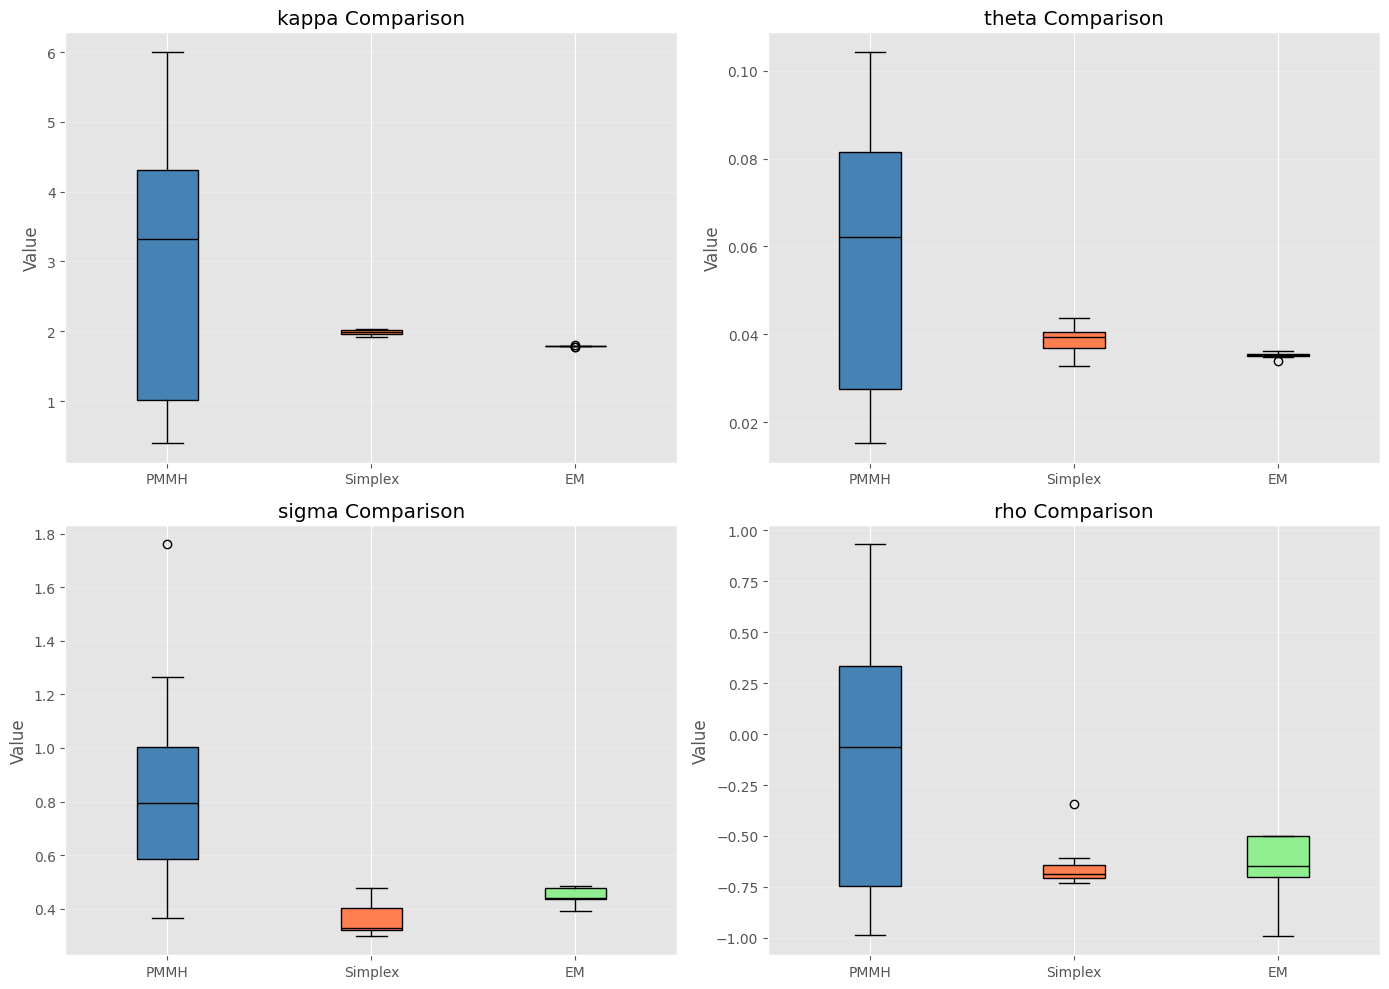

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

param_names = ['kappa', 'theta', 'sigma', 'rho']
methods = ['PMMH', 'Simplex', 'EM']

for i, param in enumerate(param_names):
    data = [
        [d[param] for d in params_pmmh_list],
        [d[param] for d in params_simplex_list],
        [d[param] for d in params_em_list],
    ]

    bp = axes[i].boxplot(
        data,
        labels=methods,
        patch_artist=True,
        boxprops=dict(facecolor='lightgray', edgecolor='black'),
        medianprops=dict(color='black'),
    )
    for box, color in zip(bp['boxes'], colors):
        box.set_facecolor(color)
        box.set_edgecolor('black')

    axes[i].set_title(f'{param} Comparison')
    axes[i].set_ylabel('Value')
    axes[i].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

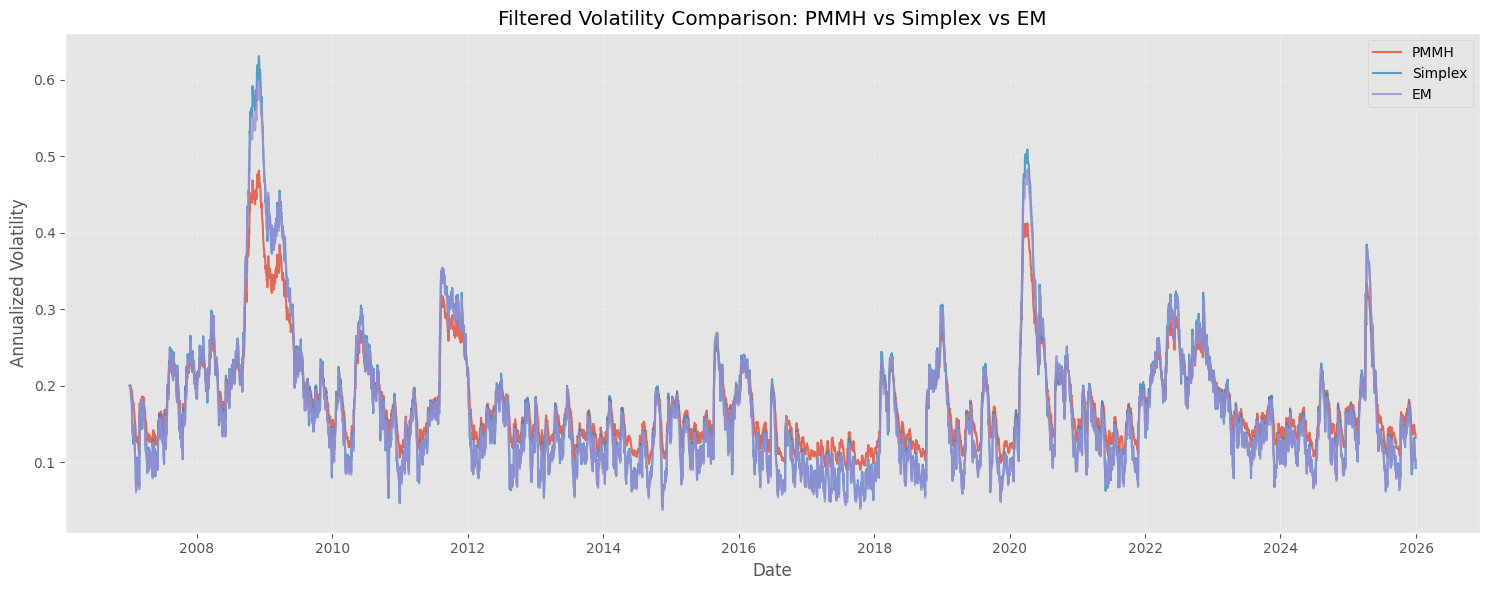

=== Volatility Correlations ===
PMMH vs Simplex: 0.9943
PMMH vs EM:      0.9956
Simplex vs EM:   0.9991


In [68]:
# Get volatility estimates from each method
# PMMH
hest.kappa = params_pmmh['kappa']
hest.theta = params_pmmh['theta']
hest.sigma = params_pmmh['sigma']
hest.rho = params_pmmh['rho']
hest.fit(n_particles=2000, verbose=False)
vol_pmmh = hest.filtered_volatility

# Simplex
hest.kappa = params_simplex['kappa']
hest.theta = params_simplex['theta']
hest.sigma = params_simplex['sigma']
hest.rho = params_simplex['rho']
hest.fit(n_particles=2000, verbose=False)
vol_simplex = hest.filtered_volatility

# EM
hest.kappa = params_em['kappa']
hest.theta = params_em['theta']
hest.sigma = params_em['sigma']
hest.rho = params_em['rho']
hest.fit(n_particles=2000, verbose=False)
vol_em = hest.filtered_volatility

# Plot comparison
plt.figure(figsize=(15, 6))
plt.plot(hest.dates, vol_pmmh, label='PMMH', linewidth=1.5, alpha=0.8)
plt.plot(hest.dates, vol_simplex, label='Simplex', linewidth=1.5, alpha=0.8)
plt.plot(hest.dates, vol_em, label='EM', linewidth=1.5, alpha=0.8)
plt.title('Filtered Volatility Comparison: PMMH vs Simplex vs EM')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate correlations
print("=== Volatility Correlations ===")
print(f"PMMH vs Simplex: {np.corrcoef(vol_pmmh, vol_simplex)[0,1]:.4f}")
print(f"PMMH vs EM:      {np.corrcoef(vol_pmmh, vol_em)[0,1]:.4f}")
print(f"Simplex vs EM:   {np.corrcoef(vol_simplex, vol_em)[0,1]:.4f}")

### Method Comparison Summary

| Method      | Type                | Advantages                                 | Disadvantages                        | Computational Cost      |
| ----------- | ------------------- | ------------------------------------------ | ------------------------------------ | ----------------------- |
| **PMMH**    | Bayesian MCMC       | Full posterior, uncertainty quantification | Slow, requires priors                | High (hours)            |
| **Simplex** | Direct optimization | Fast, simple, no priors                    | Local minima, no uncertainty         | Medium (minutes)        |
| **EM**      | Iterative           | Guaranteed improvement, good for SSMs      | Slow convergence, approximate M-step | Medium-High (10-30 min) |

### Discussion

1. **PMMH** is the most theoretically sound method, providing full Bayesian inference with uncertainty quantification. However, it's computationally expensive.

2. **Simplex** is the fastest method and often finds good solutions, but may get stuck in local minima and doesn't provide uncertainty estimates.

3. **EM** is a good middle ground, but for the Heston model, the M-step is approximate (requires numerical optimization), which limits its effectiveness.

4. **Paper's approach (NMLE)**: The paper uses NMLE which requires known volatilities, so it alternates between filtering and parameter estimation. This is similar to EM but uses a different parameter update rule.


## Conclusions

### Step 2 Summary

This notebook successfully addresses **Step 2** of the project requirements:

1.  **Explained paper's approach**: NMLE with switching filters (PCRLB-based)
2.  **Compared estimation methods**: PMMH, Simplex, and EM
3.  **Analyzed differences**: Computational cost, advantages, disadvantages
4.  **Visualized results**: Parameter comparisons and volatility paths

### Key Findings

- **PMMH** provides the most complete inference but is computationally expensive
- **Simplex** is fast and practical for point estimates
- **EM** is theoretically appealing but implementation for Heston model is challenging
- All methods can produce reasonable parameter estimates, but may differ due to:
  - Different optimization objectives
  - Local vs global optima
  - Computational constraints
